# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchinfo
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from os import listdir


from torch.utils.data import DataLoader, Dataset

import torch.nn.functional as F

from os.path import join as pjoin

from torchmetrics.classification import MulticlassStatScores

from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image

# Const

In [2]:
DEVICE = torch.device("cuda")
DEVICE_CPU = torch.device("cpu")

EPOCHS = 30

BATCH_SIZE = 96

LEARNING_RATE = 0.004

PATH_TO_TRAIN = "C:\AI_PAK\AI\simpson\simpsons_train"
PATH_TO_TEST = "C:\AI_PAK\AI\simpson\simpsons_test"

LABELS = dict((name, index) for (index, name) in enumerate(listdir(PATH_TO_TRAIN)))
COUNT_LABELS = len(LABELS)

RESIZE = (64, 64)

MEAN = (0.5, 0.5, 0.5)
STD = (0.25, 0.25, 0.25)

GAMMA = torch.tensor([1.0, 1.0, 1.0])
BETA = torch.tensor([0, 0, 0])

# Transformer

In [3]:
TRANSFORM = transforms.Compose([
    transforms.Resize(size=RESIZE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Dataset To Train

In [5]:
class Image_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.paths = list()
        self.labels = list()
        for label in LABELS: 
            elements = glob.glob(os.path.join(PATH_TO_TRAIN, label, "*.jpg"))
            self.paths.extend(elements)
            self.labels.extend([LABELS.get(label)] * len(elements))
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        with open(self.paths[index], "rb") as file:
            image = Image.open(file).convert("RGB")
        image = TRANSFORM(image)
        return image, torch.tensor(self.labels[index], dtype=torch.long)

In [6]:
full_dataset = Image_Dataset()
generator = torch.Generator().manual_seed(42)
dataset_train, dataset_valid = torch.utils.data.random_split(full_dataset, [0.9, 0.1], generator=generator)
dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 

# Model

In [4]:
def fusing(conv, bn):
    w = conv.weight
    mean = bn.running_mean
    var_sqrt = torch.sqrt(bn.running_var + bn.eps)

    beta = bn.weight
    gamma = bn.bias

    if conv.bias is not None:
        b = conv.bias
    else:
        b = mean.new_zeros(mean.shape)

    w = w * (beta / var_sqrt).reshape([conv.out_channels, 1, 1, 1])
    b = (b - mean)/var_sqrt * beta + gamma

    fused_conv = nn.Conv2d(
        conv.in_channels,
        conv.out_channels,
        conv.kernel_size,
        conv.stride,
        conv.padding,
        conv.dilation,
        conv.groups,
        bias=True,
        padding_mode=conv.padding_mode
    )
    fused_conv.weight = nn.Parameter(w)
    fused_conv.bias = nn.Parameter(b)
    return fused_conv

In [5]:
def merge_two_conv(conv1, conv2):
    in_channels = conv1.weight.size()[0]
    out_channels = conv2.weight.size()[0]

    new_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

    count_i = 0
    for i in new_conv.weight.data:
        count_j = 0
        new_conv.bias.data[count_i] = conv2.bias.data[count_i]
        for j in new_conv.weight.data[count_i]:
            new_conv.weight.data[count_i][count_j] = conv1.weight.data[count_j][0] * conv2.weight.data[count_i][count_j][0][0]
            new_conv.bias.data[count_i] += conv2.weight.data[count_i][count_j][0][0] * conv1.bias.data[count_j]
            count_j += 1
        count_i += 1

    return new_conv

In [6]:
class Block(nn.Module):
    def __init__(self, inC: int, outC: int, mult: int) -> None:
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.silu = nn.SiLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels=inC, out_channels=inC*mult, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(inC*mult)
        self.conv2 = nn.Conv2d(in_channels=inC*mult, out_channels=inC*mult, kernel_size=3, padding=1, groups=inC*mult)
        self.bn2 = nn.BatchNorm2d(inC*mult)
        self.conv3 = nn.Conv2d(in_channels=inC*mult, out_channels=outC, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(outC)
        self.activeted = 0
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=inC, out_channels=outC, kernel_size=1),
            nn.BatchNorm2d(outC)
        )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # fused model
        if (self.activeted == 0):
            self.buff = fusing(merge_two_conv(fusing(self.conv2, self.bn2), self.conv3), self.bn3)
            self.activeted = 1
        out = self.buff(out)

        # out = self.conv2(out)
        # out = self.bn2(out)
        # out = self.silu(out) # no use if wanna use fused model for test

        # out = self.conv3(out)
        # out = self.bn3(out)

        identity = self.downsample(identity)

        out += identity
        out = self.relu(out)
        x = out
        return x

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.cv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32)
        )
        self.cv2 = nn.Sequential(
            Block(32, 32, 6),
            Block(32, 32, 6),
            nn.Dropout(0.2),
            Block(32, 64, 6),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.cv3 = nn.Sequential(
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 64, 6),
            Block(64, 64, 6),
            nn.Dropout(0.2),
            Block(64, 128, 6),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.cv4 = nn.Sequential(
            Block(128, 128, 6),
            Block(128, 128, 6),
            Block(128, 128, 6),
            nn.Dropout(0.2),
            Block(128, 256, 6),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.cv5 = nn.Sequential(
            Block(256, 256, 6),
            Block(256, 256, 6),
            nn.Dropout(0.2),
            Block(256, 512, 6),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.Dropout(0.2),
            nn.Linear(128, COUNT_LABELS)
        )
    
    def forward(self, x):
        x = self.cv1(x)
        x = self.cv2(x)
        x = self.cv3(x)
        x = self.cv4(x)
        x = self.cv5(x)
        x = self.fc(x)

        return x

In [8]:
model = Model().to(DEVICE_CPU)

In [ ]:
# Info about model
print(model_sum := torchinfo.summary(model, depth=4, input_size=(BATCH_SIZE, 3, *RESIZE), row_settings=["var_names"], verbose=0, col_names=[
"input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]))

# Save Weights

In [33]:
torch.save(model.state_dict(), "model_weights_3_no_silu.pth")

# Load Weights

In [9]:
model.load_state_dict(torch.load("model_weights_30_no_silu.pth"))

<All keys matched successfully>

# Train

In [13]:
loss_to_stats = []
loss_to_stats_valid = []

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.0001)

for epoch in range(EPOCHS):
    res = 0
    count = 0
    for images, labs in dataloader:
        model.train()
        optimizer.zero_grad()

        images, labs = images.to(DEVICE), labs.to(DEVICE)

        out = model(images)
        loss = criterion(out, labs)
        loss.backward()
        optimizer.step()
        
        print(f"epoch = {epoch}  loss = {loss} ")
        
        res += loss
        count += 1 
    loss_to_stats.append(res/count)
    res = 0
    count = 0
    for images, labs in dataloader_valid:
        model.eval()
        with torch.no_grad():
            images, labs = images.to(DEVICE), labs.to(DEVICE)

            out = model(images)
            loss = criterion(out, labs)
            res += loss
        count += 1 
    loss_to_stats_valid.append(res/count)

    print(f"\nepoch = {epoch} finish\n")


epoch = 0  loss = 3.7603719234466553 
epoch = 0  loss = 3.5941340923309326 
epoch = 0  loss = 3.6222355365753174 
epoch = 0  loss = 3.156660795211792 
epoch = 0  loss = 3.2853822708129883 
epoch = 0  loss = 3.3012588024139404 
epoch = 0  loss = 3.12050724029541 
epoch = 0  loss = 3.3216283321380615 
epoch = 0  loss = 3.4943549633026123 
epoch = 0  loss = 3.1248292922973633 
epoch = 0  loss = 3.259552001953125 
epoch = 0  loss = 3.331319808959961 
epoch = 0  loss = 3.137044668197632 
epoch = 0  loss = 3.135890245437622 
epoch = 0  loss = 3.297093152999878 
epoch = 0  loss = 3.285292387008667 
epoch = 0  loss = 3.208571434020996 
epoch = 0  loss = 3.2278177738189697 
epoch = 0  loss = 3.3908679485321045 
epoch = 0  loss = 3.1300363540649414 
epoch = 0  loss = 3.1963987350463867 
epoch = 0  loss = 3.0630359649658203 
epoch = 0  loss = 3.153587579727173 
epoch = 0  loss = 3.0409231185913086 
epoch = 0  loss = 3.1183741092681885 
epoch = 0  loss = 3.214320421218872 
epoch = 0  loss = 3.1156

# Loss On Train

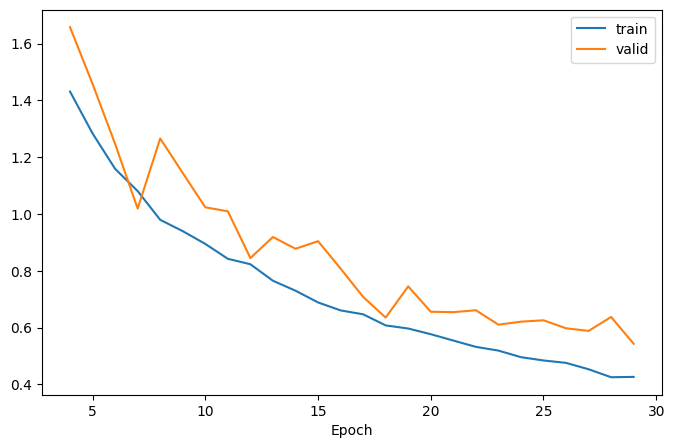

In [28]:
arr_train = np.array([i.item() for i in loss_to_stats])
arr_valid = np.array([i.item() for i in loss_to_stats_valid])

fig = plt.figure(figsize=(8, 5))

plt.plot(np.array([i for i in range(len(arr_train))][4:]), arr_train[4:], label='train')
plt.plot(np.array([i for i in range(len(arr_valid))][4:]), arr_valid[4:], label='valid')
plt.legend()
plt.xlabel("Epoch")

plt.show()

30 epoch no silu

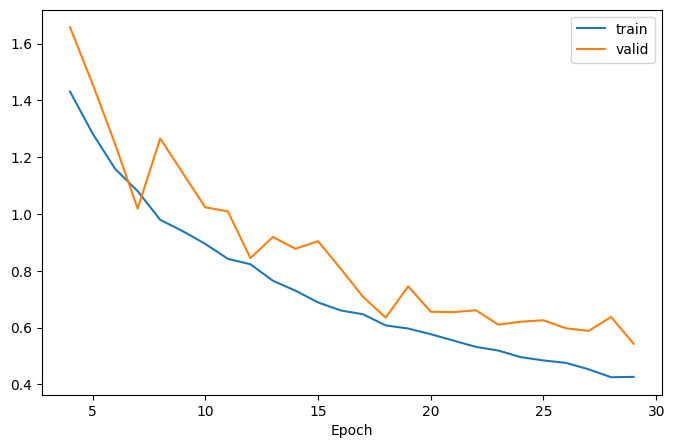

# Dataset for Test

In [10]:
res = list(LABELS.keys())
CLASSES = np.array(res)

class SimpsonTestDataset(Dataset):
    def __init__(self, img_dir):
        self.files = []
        for _, _, files in os.walk(img_dir):
            self.files += files
        self.calculateClasses()
        self.img_dir = img_dir

    def extractName(self, s):
        se = re.search(r"[a-zA-Z_]+[^\d]?", s)
        return se.group(0)[:-1]

    def calculateClasses(self):
        self.s = set()
        for i in self.files:
            self.s.add(self.extractName(i))
        return list(self.s)

    @property
    def classes(self):
        return list(self.s)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.files[index])
        with open(img_path, "rb") as file:
            image = Image.open(file).convert("RGB")
        label = self.extractName(self.files[index])

        image = TRANSFORM(image)
        label = np.where(CLASSES == label)[0][0]
        return image, label

In [11]:
test_dataset = SimpsonTestDataset(PATH_TO_TEST)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, num_workers=0)

# Test

In [12]:
stats = MulticlassStatScores(num_classes=COUNT_LABELS, average=None).to(DEVICE_CPU)

with torch.no_grad():
    model.eval()
    pic = 0
    for images, labels in test_dataloader:
        images = images.to(DEVICE_CPU)
        labels = labels.to(DEVICE_CPU)

        outputs = model(images)
        stats.update(outputs, labels)

tp, fp, tn, fn = stats._final_state()

# Metrics

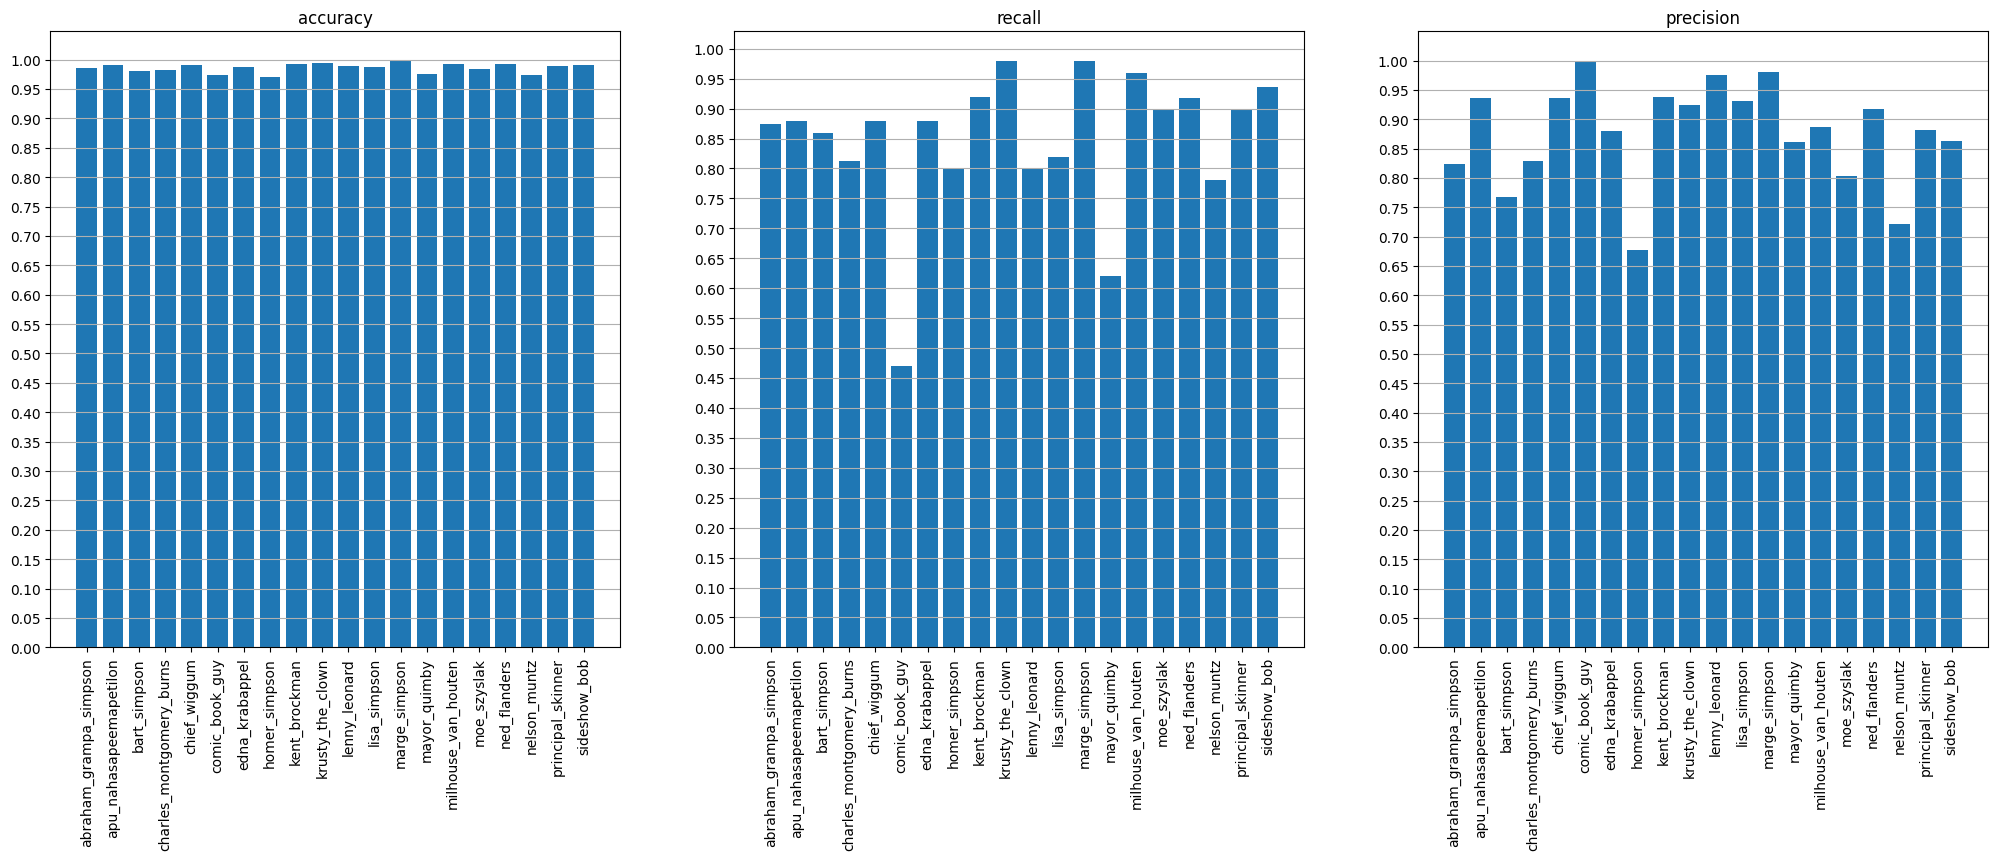



Test:
accuracy: 99.2785%
recall: 84.8531%
precision: 87.6969%
F: 86.2515%


In [13]:
def metric(a, b):
    return torch.nan_to_num(a / b)

def metrics_class(a, b):
    return {classname: val.item() for classname, val in zip(CLASSES, metric(a, b)) if classname in test_dataset.classes}

metrics_per_class = {"accuracy": metrics_class(tp + tn, tp + fp + tn + fn),
                     "recall": metrics_class(tp, tp + fn),
                     "precision": metrics_class(tp, tp + fp)}

def metrics_total(a, b, len=COUNT_LABELS):
    return sum(metric(a, b)) / len

metric_total = {"accuracy": metrics_total(tp + tn, tp + fp + tn + fn),
                "recall": metrics_total(tp, tp + fn, len(test_dataset.classes)),
                "precision": metrics_total(tp, tp + fp, len(test_dataset.classes))}


fig, axes = plt.subplots(1, 3, figsize=(25,8))

for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
        plt.sca(ax)
        plt.bar(mVal.keys(), mVal.values())
        plt.title(metricName)
        plt.grid(axis='y')
        plt.xticks(rotation=90)
        plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

result = f"""\n\nTest:
accuracy: {metric_total['accuracy']*100:.4f}%
recall: {metric_total['recall']*100:.4f}%
precision: {metric_total['precision']*100:.4f}%
F: {2 * metric_total['precision']*metric_total['recall']/(metric_total['precision']+metric_total['recall'])*100:.4f}%"""

print(result)

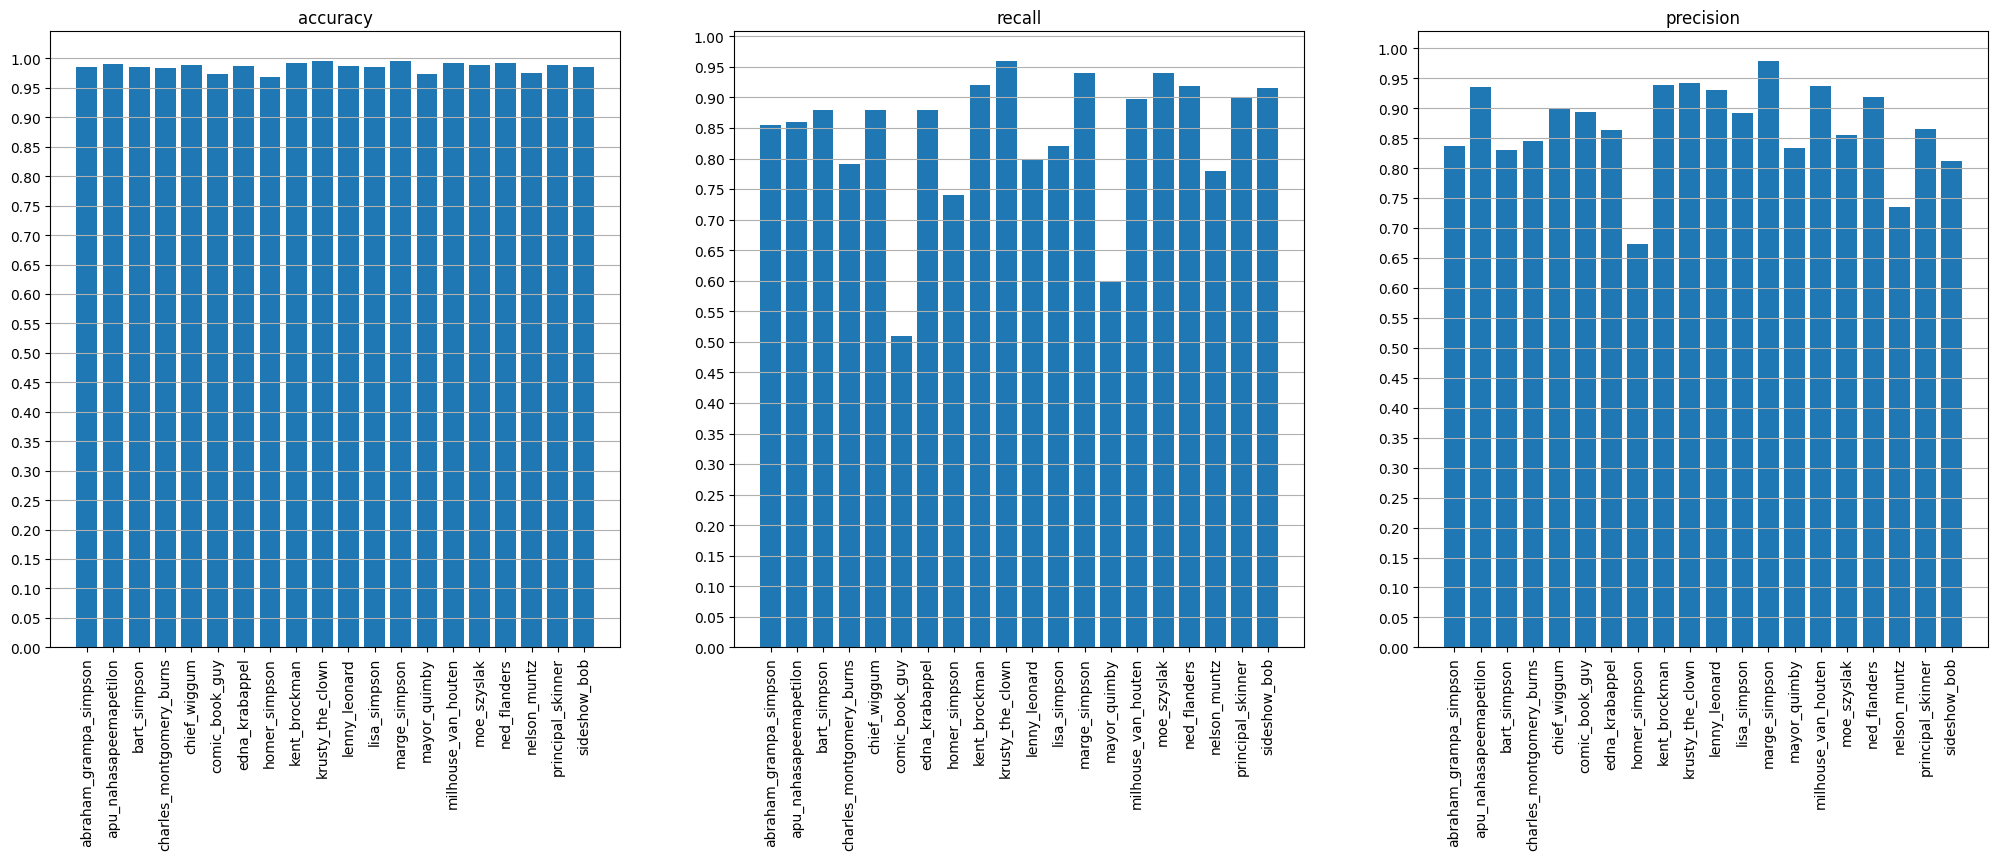